# Tutorial 2: Large Deformation and h and p Refinement

In [1]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
%matplotlib inline

In [2]:
# for saving files later
tutorials_dir = Path.cwd()

## h refinement

In [3]:
# Set up a 2D cantilever beam under a uniform downward traction on the top edge.
# The left edge (x=0) is clamped. For small deflection, compare the tip displacement
# at x=L, y=H/2 with the Euler–Bernoulli beam formula:
# For a cantilever of length L, height H, uniform load q, plane strain,
#   Material:
#         E = 100000, nu = 0.3.
#     Derived:
#         mu    = E/(2*(1+nu))
#         kappa = E/(3*(1-2*nu))
    
#     Analytical tip deflection for a cantilever beam under uniform load q is:
#         w(L) = q*L^4 / (8*E*I),   I = H^3/12.


# --- Beam geometry ---
L = 10.0   # length in x
H = 1.0    # height in y

ele_type = "D2_nn4_quad"  # 2D, 4-node quadrilateral (linear)
ndof = 2                  # 2 DOFs per node (x, y)

# --- Material properties ---
E = 100000.0
nu = 0.3
# mu = E / (2.0 * (1.0 + nu))
# kappa = E / (3.0 * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
#kappa = E / (2.0 * (1.0 - nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])

# Number of incremental load steps
nr_num_steps = 1

In [ ]:
no_of_element = np.array([2,5,10,15,20]) # Mesh refinement factor

displacement_tip = []

for n in no_of_element:
    nx = int(L*n)
    ny = int(H*n)
    # Generate a rectangular mesh
    coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)
    # coords: shape (n_nodes, 2)
    # connect: shape (n_nodes_per_elem, n_elems)

    # --- Identify boundaries ---
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
        coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
    )

    # 1) Clamp the left edge: fix x- and y-displacements = 0
    fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

    # 2) Uniform downward traction on the top edge (y=H)
    # Let q be negative in the y-direction
    
    ## Larger load
    q = -10  # load per unit length in x

    # For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
    dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)
    
    # Combine boundary conditions
    fixed_nodes = fixed_left  # only the left edge is clamped
    # --- Solve with your hyperelastic solver ---
    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,      # shape (2, n_nodes)
        connect.T,     # shape (n_nodes_per_elem, n_elems)
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-10,
        nr_maxit=30,
    )

    final_disp = displacements_all[-1]  # shape: (n_nodes*ndof,)

    # --- Compute the tip displacement from the FEA result ---
    # We'll pick a node near x=L, y=H/2
    tip_node = None
    tol = 1e-3
    for i, (x, y) in enumerate(coords):
        if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
            tip_node = i
            break
    if tip_node is None:
        raise ValueError("Could not find tip node near x=L, y=H/2.")

    tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement
    
    displacement_tip.append(tip_disp_y.copy())

Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=1.741064e-01, tolerance=1.000000e-10
Iteration 2, Correction=6.223415e-02, Residual=4.579933e+01, tolerance=1.000000e-10
Iteration 3, Correction=1.261757e-02, Residual=5.375525e-01, tolerance=1.000000e-10
Iteration 4, Correction=2.490649e-03, Residual=1.088784e-02, tolerance=1.000000e-10
Iteration 5, Correction=9.823810e-06, Residual=4.198241e-04, tolerance=1.000000e-10
Iteration 6, Correction=1.519824e-09, Residual=6.739163e-09, tolerance=1.000000e-10
Iteration 7, Correction=2.979954e-15, Residual=4.527493e-13, tolerance=1.000000e-10
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=2.293410e-02, tolerance=1.000000e-10
Iteration 2, Correction=6.935107e-02, Residual=7.606955e+00, tolerance=1.000000e-10
Iteration 3, Correction=1.252511e-02, Residual=1.114566e-01, tolerance=1.000000e-10
Iteration 4, Correction=4.361971e-03, Residual=1.869430e-03, tolerance=1.000000e-10
Iteration 5, Correct

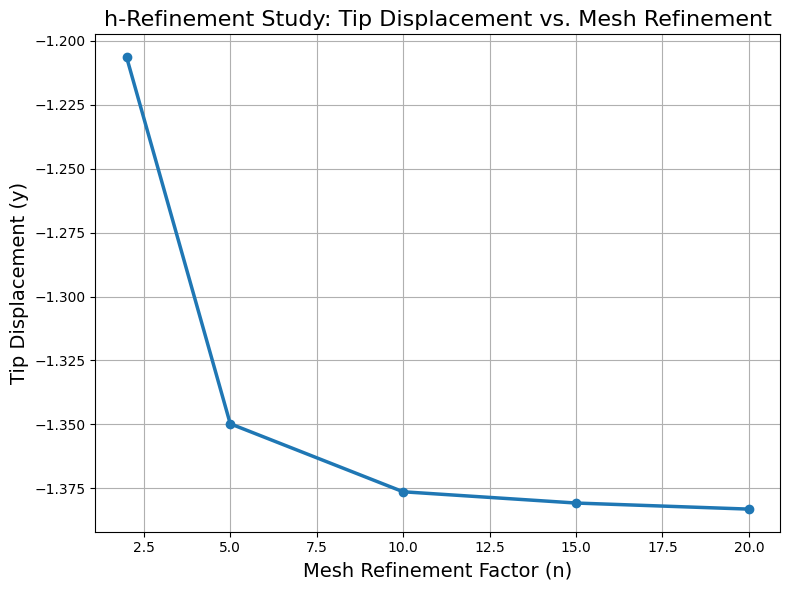

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(no_of_element, displacement_tip, marker='o', linewidth=2.5)
plt.xlabel("Mesh Refinement Factor (n)", fontsize=14)
plt.ylabel("Tip Displacement (y)", fontsize=14)
plt.title("h-Refinement Study: Tip Displacement vs. Mesh Refinement", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("h_refinement_tip_displacement.png", dpi=300)

## p-refinement

In [ ]:
element_type = ["D2_nn3_tri","D2_nn4_quad","D2_nn6_tri","D2_nn8_quad"] # Different element types

nx = 20
ny = 20

displacement_tip_p_refinement = []

for ele_type in element_type:
    # Generate a rectangular mesh
    coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)
    # coords: shape (n_nodes, 2)
    # connect: shape (n_nodes_per_elem, n_elems)

    # --- Identify boundaries ---
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
        coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
    )

    # 1) Clamp the left edge: fix x- and y-displacements = 0
    fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

    # 2) Uniform downward traction on the top edge (y=H)
    # Let q be negative in the y-direction
    q = -10  # load per unit length in x
    # For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
    dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)
    
    # Combine boundary conditions
    fixed_nodes = fixed_left  # only the left edge is clamped
    # --- Solve with your hyperelastic solver ---
    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,      # shape (2, n_nodes)
        connect.T,     # shape (n_nodes_per_elem, n_elems)
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-10,
        nr_maxit=30,
    )

    final_disp = displacements_all[-1]  # shape: (n_nodes*ndof,)

    # --- Compute the tip displacement from the FEA result ---
    # We'll pick a node near x=L, y=H/2
    tip_node = None
    tol = 1e-3
    for i, (x, y) in enumerate(coords):
        if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
            tip_node = i
            break
    if tip_node is None:
        raise ValueError("Could not find tip node near x=L, y=H/2.")

    tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement
    
    displacement_tip_p_refinement.append(tip_disp_y.copy())    

Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=2.487235e-02, tolerance=1.000000e-10
Iteration 2, Correction=5.581897e-02, Residual=5.112308e+00, tolerance=1.000000e-10
Iteration 3, Correction=1.181801e-02, Residual=4.811967e-02, tolerance=1.000000e-10
Iteration 4, Correction=1.361899e-03, Residual=1.043963e-03, tolerance=1.000000e-10
Iteration 5, Correction=3.400101e-06, Residual=1.387339e-05, tolerance=1.000000e-10
Iteration 6, Correction=1.143714e-10, Residual=8.836683e-11, tolerance=1.000000e-10
Iteration 7, Correction=7.332311e-16, Residual=2.572162e-12, tolerance=1.000000e-10
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=2.487235e-02, tolerance=1.000000e-10
Iteration 2, Correction=6.526685e-02, Residual=7.012639e+00, tolerance=1.000000e-10
Iteration 3, Correction=1.264039e-02, Residual=8.973194e-02, tolerance=1.000000e-10
Iteration 4, Correction=3.187030e-03, Residual=1.673206e-03, tolerance=1.000000e-10
Iteration 5, Correct

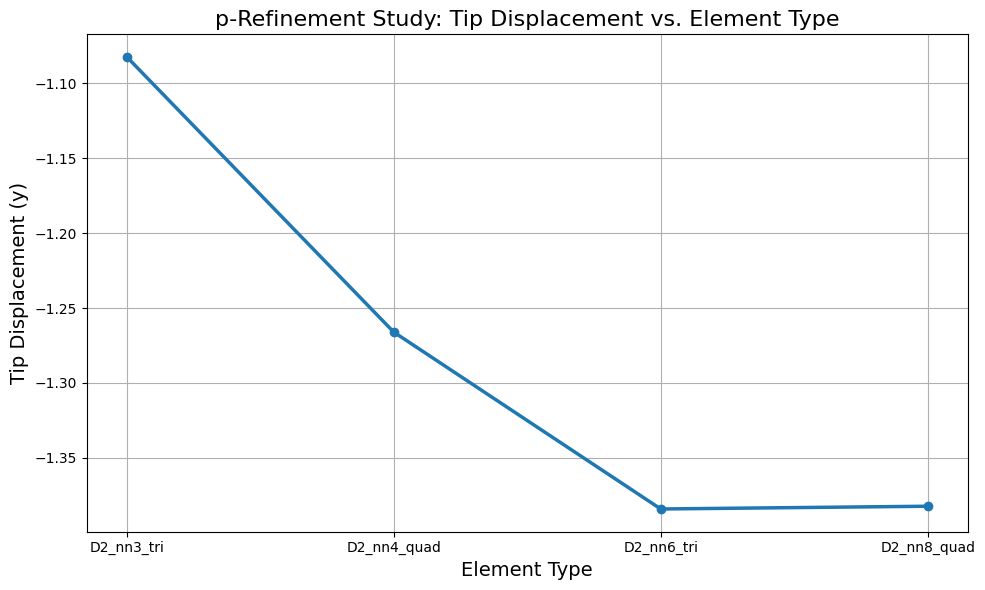

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(element_type, displacement_tip_p_refinement, marker='o', linewidth=2.5)
plt.xlabel("Element Type", fontsize=14)
plt.ylabel("Tip Displacement (y)", fontsize=14)
plt.title("p-Refinement Study: Tip Displacement vs. Element Type", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("p_refinement_tip_displacement.png", dpi=300)